## Image augmentation using keras ImageDataGenerator

In [1]:
# building data generator
from keras.preprocessing.image import ImageDataGenerator

base_path = "./images/"
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    rotation_range=5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    base_path + "train",
    target_size=(48, 48),
    subset="training",
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = valid_datagen.flow_from_directory(
    base_path + 'train',
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode='categorical',
    subset='validation',
    batch_size=batch_size
)

test_data_generator = test_datagen.flow_from_directory(
    base_path + "validation",
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
)


2022-10-23 17:03:36.668115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 17:03:36.773033: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-23 17:03:37.154110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.1/targets/x86_64-linux/lib:/usr/local/cuda-11.7/targets/x86_64-linux/lib
2022-10-23 17:03:37.154151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Defining our 4 Convolution and 2 Dense layers model

In [2]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation
from keras.models import Sequential
from keras.applications import EfficientNetV2B0, ResNet50
from keras.optimizers import Adam
from keras import optimizers, layers
from keras.metrics import AUC, CategoricalAccuracy, Precision, Recall


# number of possible label values
nb_classes = 7
IMAGE_SIZE = 48

base_model = EfficientNetV2B0(input_shape=(
    48, 48, 3), include_top=False, weights="imagenet")

model = Sequential([
    base_model,
    Dropout(0.5),
    Flatten(),
    BatchNormalization(),

    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dense(7, activation='softmax'),
])
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[
    CategoricalAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),  
    AUC(name='auc'),
])


2022-10-23 17:03:38.208476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 17:03:38.227871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 17:03:38.228014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 17:03:38.228481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 2, 2, 1280)       5919312   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 2, 2, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 batch_normalization (BatchN  (None, 5120)             20480     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                163872    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               1

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(verbose=1,patience=20)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, min_lr=1e-10)

In [4]:
# number of epochs to train the NN
from keras.callbacks import ModelCheckpoint
epochs = 100

# checkpoint to save best model
mcp = ModelCheckpoint('model_effNet.h5')
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[reduce_lr,es],
    verbose=1
)

Epoch 1/100


2022-10-23 17:03:45.998928: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


361/361 [==============================] - 30s 62ms/step - loss: 2.1436 - accuracy: 0.1455 - precision: 0.1705 - recall: 0.0079 - auc: 0.5035 - val_loss: 1.9280 - val_accuracy: 0.1673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5608 - lr: 1.0000e-04
Epoch 2/100
361/361 [==============================] - 21s 58ms/step - loss: 2.0194 - accuracy: 0.1814 - precision: 0.2205 - recall: 0.0078 - auc: 0.5546 - val_loss: 1.8894 - val_accuracy: 0.2168 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6138 - lr: 1.0000e-04
Epoch 3/100
361/361 [==============================] - 21s 59ms/step - loss: 1.9596 - accuracy: 0.1929 - precision: 0.2259 - recall: 0.0066 - auc: 0.5852 - val_loss: 1.8637 - val_accuracy: 0.2420 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6344 - lr: 1.0000e-04
Epoch 4/100
361/361 [==============================] - 21s 57ms/step - loss: 1.9216 - accuracy: 0.2046 - precision: 0.2625 - recall: 0.0066 - auc: 0.6030 - val_

In [5]:
from matplotlib import pyplot as plt

# visualise training and testing accuracy and loss

def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    auc = history.history['auc']
    val_auc = history.history['val_auc']

    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, auc, 'b', label='Training AUC')
    plt.plot(epochs, val_auc, 'r', label='Validation AUC')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, precision, 'b', label='Training Precision')
    plt.plot(epochs, val_precision, 'r', label='Validation Precision')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, recall, 'b', label='Training Recall')
    plt.plot(epochs, val_recall, 'r', label='Validation Recall')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

# print best epoch with best accuracy on validation


def get_best_epoch(history):
    valid_acc = history.history['val_accuracy']
    valid_auc = history.history['val_auc']
    valid_precision = history.history['val_precision']
    valid_recall = history.history['val_recall']
    
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc = max(valid_acc)

    best_epoch_auc = valid_auc.index(max(valid_auc)) + 1
    best_auc = max(valid_auc)

    best_epoch_precision = valid_precision.index(max(valid_precision)) + 1
    best_precision = max(valid_precision)

    best_epoch_recall = valid_recall.index(max(valid_recall)) + 1
    best_recall = max(valid_recall)

    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format(
        best_acc, best_epoch))
    print('Best Validation AUC {:0.5f}, is for epoch {}'.format(
        best_auc, best_epoch_auc))
    print('Best Validation Precision {:0.5f}, is for epoch {}'.format(
        best_precision, best_epoch_auc))
    print('Best Validation Recall {:0.5f}, is for epoch {}'.format(
        best_recall, best_epoch_auc))


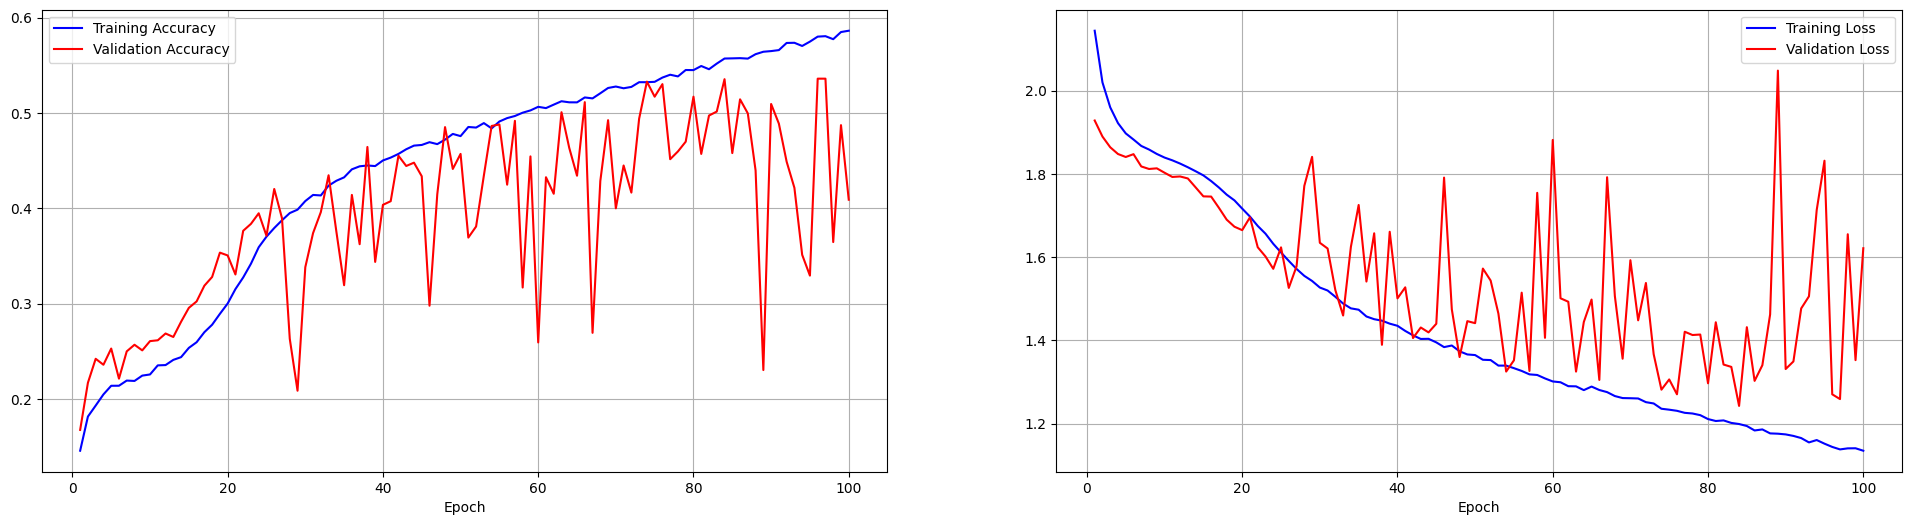

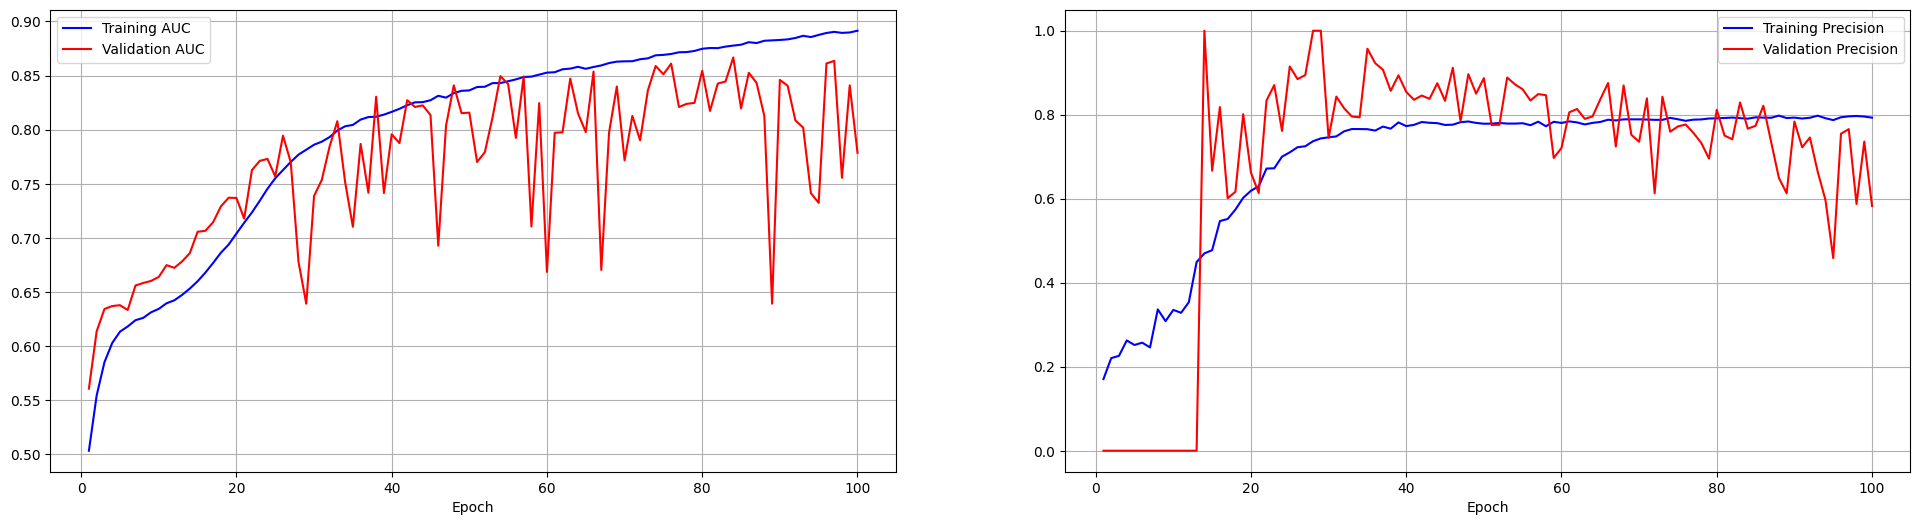

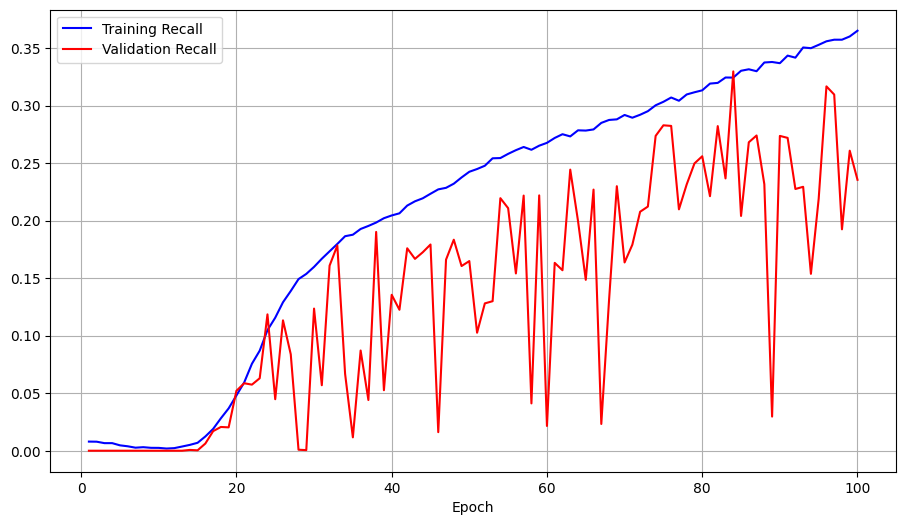

Best Validation Accuracy Score 0.53602, is for epoch 96
Best Validation AUC 0.86677, is for epoch 84
Best Validation Precision 1.00000, is for epoch 84
Best Validation Recall 0.32980, is for epoch 84


In [6]:
plot_results(history)
get_best_epoch(history)

In [7]:
model.evaluate(test_data_generator)

111/111 [==============================] - 2s 13ms/step - loss: 1.6109 - accuracy: 0.4065 - precision: 0.6023 - recall: 0.2403 - auc: 0.7806


[1.6108607053756714,
 0.4064534306526184,
 0.6023412346839905,
 0.24030569195747375,
 0.7805619239807129]